## Credit Analytics Case Study

Two data files are provided:
1. "Origination Data.csv" provides characteristics of student loans that have been originated.
2. The second file, "Performance.xlsx", is a performance summary of loans. The "Early Risk Score" is an indicator of poor credit performance (the higher the score, the riskier the loan).

Review the two files and analyze the data to determine if there are any loan characteristics (in the Origination Data file) that are predictive of the Early Risk Score.

In [191]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading and Understanding the data

In [193]:
# Reading origination data
origin = pd.read_csv('E:\DataScience\JobSearch\MpowerFinance\Origination_Data.csv')
origin

,Loan Number,Tell Us About You,Has SSN,US Citizen,Enrollment Status,STEM,Credit Score 1,Credit Score 2,GPA,Approved Loan Amount,Interest Rate,Test Loan
0,35,NaN,Yes,False,2nd Year Graduate,No,630.0,0.0,3.74,15500.0,11.99,0
1,40,NaN,Yes,True,4th Year Undergraduate,No,536.0,NaN,3.20,10000.0,9.99,0
2,43,NaN,Yes,False,2nd Year Graduate,No,644.0,NaN,3.86,10446.0,11.99,0
3,63,NaN,Yes,False,4th Year Undergraduate,No,688.0,NaN,3.20,15000.0,13.99,0
4,65,NaN,No,False,1st Year Graduate,No,NaN,NaN,0.00,7000.0,11.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1006,2313,I am currently enrolled,No,False,3rd Year Graduate,No,712.0,0.0,0.00,25000.0,11.99,0
1007,2316,I am currently enrolled,No,False,1st Year Graduate,No,NaN,0.0,0.00,10000.0,11.99,0
1008,2317,I am currently enrolled,Yes,False,2nd Year Graduate,No,756.0,0.0,2.80,21000.0,11.99,0
1009,2318,I am currently enrolled,Yes,False,1st Year Graduate,No,NaN,NaN,3.80,10000.0,11.99,0


In [194]:
origin.shape

(1011, 12)

In [195]:
# Reading performance data
performance = pd.read_excel('E:\DataScience\JobSearch\MpowerFinance\Performance.xlsx')
performance

,Loan Number,Early Risk Score
0,35,0.0
1,43,0.0
2,63,0.0
3,65,0.5
4,66,0.0
...,...,...
1042,2316,0.0
1043,2317,0.0
1044,2318,0.0
1045,2320,0.0


In [196]:
performance.shape

(1047, 2)

In [197]:
# Removing duplicates from performance data
performance.drop_duplicates(keep='first', inplace=True)

In [198]:
# Inner merge of two dataframes
data = pd.merge(origin, performance, on='Loan Number', how='inner')
data.head()

,Loan Number,Tell Us About You,Has SSN,US Citizen,Enrollment Status,STEM,Credit Score 1,Credit Score 2,GPA,Approved Loan Amount,Interest Rate,Test Loan,Early Risk Score
0,35,NaN,Yes,False,2nd Year Graduate,No,630.0,0.0,3.74,15500.0,11.99,0,0.0
1,43,NaN,Yes,False,2nd Year Graduate,No,644.0,NaN,3.86,10446.0,11.99,0,0.0
2,63,NaN,Yes,False,4th Year Undergraduate,No,688.0,NaN,3.20,15000.0,13.99,0,0.0
3,65,NaN,No,False,1st Year Graduate,No,NaN,NaN,0.00,7000.0,11.99,0,0.5
4,66,NaN,No,True,3rd Year Undergraduate,No,641.0,NaN,3.00,15000.0,9.99,0,0.0


In [199]:
data.shape

(958, 13)

In [200]:
# Checking percentage of missing values in the column
(round(100*(data.isnull().sum()/len(data.index)),2))

Loan Number              0.00
Tell Us About You       30.48
Has SSN                  0.00
US Citizen               0.00
Enrollment Status        0.00
STEM                     3.86
Credit Score 1          54.28
Credit Score 2          34.03
GPA                      0.00
Approved Loan Amount     0.00
Interest Rate            0.00
Test Loan                0.00
Early Risk Score         0.00
dtype: float64

We can notice that Credit Score 1 and Credit Score 2 has hige missing values. We will look at the distribution of these two variables and then decide if we can impute the missing values

## Exploratory Data Analysis

### Tareget variable :- Early Risk Score

In [201]:
data['Early Risk Score'].describe()

count    958.000000
mean       0.490710
std        1.072652
min        0.000000
25%        0.000000
50%        0.000000
75%        0.400000
max        5.000000
Name: Early Risk Score, dtype: float64

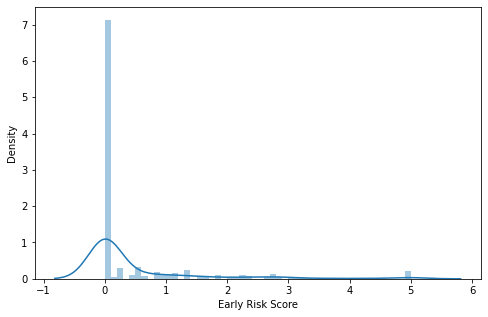

In [202]:
# Distribution of Early Risk Score
plt.figure(figsize=(8,5))
sns.distplot(data['Early Risk Score'])
plt.show()

We can see from the above distribution that the Early Risk Score is close to zero for most of the students and it is high for very less number of students. Hence the data is right skewed. 

### US Citizen 

In [203]:
# Count of the students
data['US Citizen'].value_counts()

False    907
True      51
Name: US Citizen, dtype: int64

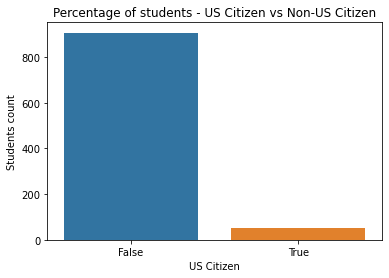

In [204]:
# Percentage of students - US Citizen vs Non US Citizen
ax = sns.countplot(x='US Citizen', data=data)
plt.title('Percentage of students - US Citizen vs Non-US Citizen')
ax.set(ylabel="Students count")
plt.show()

We can see from the above graph that out of 958 students only 51 students are US Citizen. There is a huge data imbalance here. 

In [205]:
# Mean Early Risk Score of the groups
us_citizen = data.groupby('US Citizen')['Early Risk Score'].mean().reset_index('US Citizen')
us_citizen

,US Citizen,Early Risk Score
0,False,0.468357
1,True,0.888235


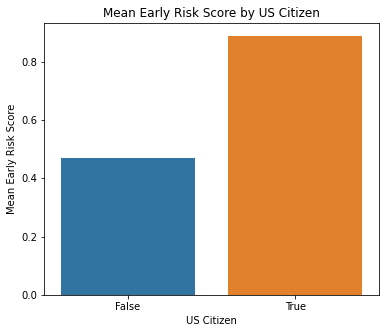

In [206]:
# Mean Early Risk Score by US Citizen
plt.figure(figsize=(6,5))
sns.barplot(x="US Citizen", y="Early Risk Score", data=us_citizen)
plt.title('Mean Early Risk Score by US Citizen')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
We can notice that the Early Risk Score is very high for US Citizen compared to Non-US Citizen.

### STEM

In [207]:
# Count of students
data['STEM'].value_counts()

No     648
Yes    273
Name: STEM, dtype: int64

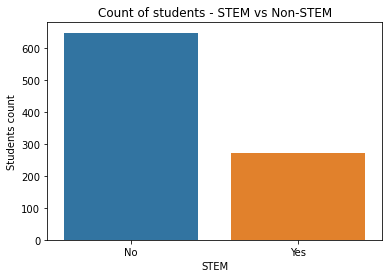

In [208]:
# Students count - STEM vs Non-STEM
ax = sns.countplot(x='STEM', data=data)
plt.title('Count of students - STEM vs Non-STEM')
ax.set(ylabel="Students count")
plt.show()

In [209]:
# Mean Early Risk Score of the groups
stem = data.groupby('STEM')['Early Risk Score'].mean().reset_index('STEM')
stem

,STEM,Early Risk Score
0,No,0.524537
1,Yes,0.377289


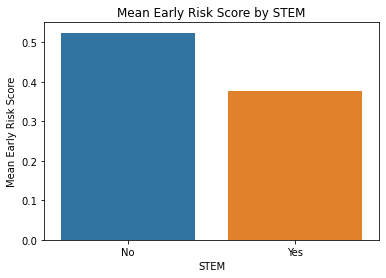

In [210]:
# Plot mean early risk score by STEM
plt.figure(figsize=(6,4))
sns.barplot(x="STEM", y="Early Risk Score", data=stem)
plt.title('Mean Early Risk Score by STEM')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
STEM course students are less riskier compared to Non-STEM course student.

### Has SSN

In [211]:
# Count of students
data['Has SSN'].value_counts()

Yes    566
No     392
Name: Has SSN, dtype: int64

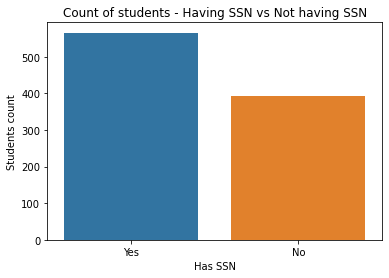

In [212]:
# Students count - Having SSN vs Not having SSN
ax = sns.countplot(x='Has SSN', data=data)
plt.title('Count of students - Having SSN vs Not having SSN')
ax.set(ylabel="Students count")
plt.show()

In [213]:
# Mean Early Risk Score of the groups
ssn = data.groupby('Has SSN')['Early Risk Score'].mean().reset_index('Has SSN')
ssn

,Has SSN,Early Risk Score
0,No,0.638776
1,Yes,0.388163


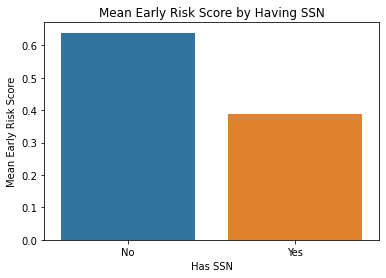

In [214]:
# Plot mean early risk score by SSN
plt.figure(figsize=(6,4))
sns.barplot(x="Has SSN", y="Early Risk Score", data=ssn)
plt.title('Mean Early Risk Score by Having SSN')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
The Risk score is very high for the students don't have SSN.

### Enrollment Status

In [215]:
# Count of students
data['Enrollment Status'].value_counts()

1st Year Graduate           483
2nd Year Graduate           214
3rd Year Undergraduate       85
4th Year Undergraduate       73
Beyond 3rd Year Graduate     43
3rd Year Graduate            36
5th Year Undergraduate       15
1st Year Undergraduate        4
2nd Year Undergraduate        4
Select enrollment status      1
Name: Enrollment Status, dtype: int64

In [216]:
# Replacing "Select enrollment status" with NAN, as "Select enrollment status" seems to be a missing value
data['Enrollment Status'].replace({'Select enrollment status': np.nan}, inplace=True)

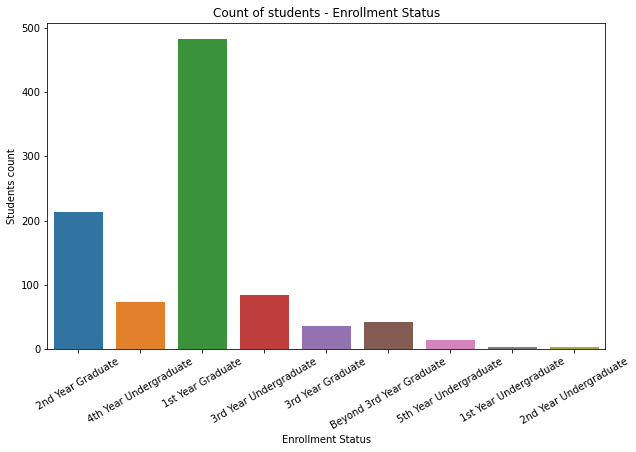

In [217]:
# Students count - Enrollment Status
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Enrollment Status', data=data)
plt.title('Count of students - Enrollment Status')
ax.set(ylabel="Students count")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

In [218]:
# Mean Early Risk Score of the groups
enrollment = data.groupby('Enrollment Status')['Early Risk Score'].mean().reset_index('Enrollment Status')
enrollment.sort_values('Early Risk Score', ascending=False)

,Enrollment Status,Early Risk Score
1,1st Year Undergraduate,1.150000
8,Beyond 3rd Year Graduate,1.034884
5,3rd Year Undergraduate,0.688235
6,4th Year Undergraduate,0.501370
2,2nd Year Graduate,0.476168
0,1st Year Graduate,0.434576
4,3rd Year Graduate,0.330556
3,2nd Year Undergraduate,0.275000
7,5th Year Undergraduate,0.073333


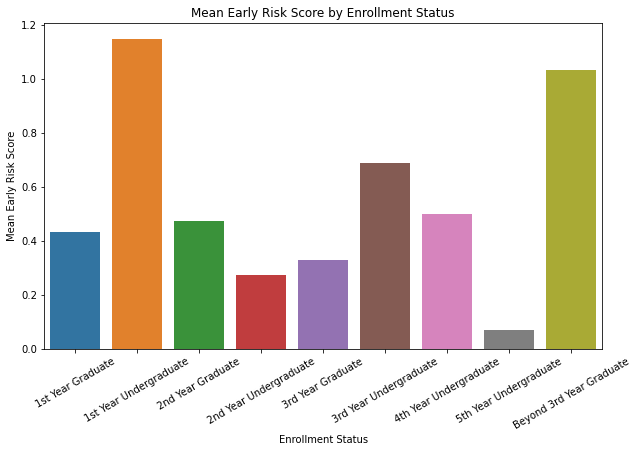

In [219]:
# Plot mean early risk score by Enrollment Status
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Enrollment Status", y="Early Risk Score", data=enrollment)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title('Mean Early Risk Score by Enrollment Status')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
`1st Year Undergraduate` and `Beyond 3rd Year Graduate` are slightly more risky than the other groups. 

### Tell Us About You

In [220]:
# Count of students
data['Tell Us About You'].value_counts()

I am currently enrolled          495
I have been accepted to study    164
I am thinking about studying       5
I have applied to study            2
Name: Tell Us About You, dtype: int64

In [221]:
# Looks like there are many missing values. Assuming many students didn't fill the details
# Replacing the missing values with NAN
data['Tell Us About You'].replace({np.nan:'None'}, inplace=True)

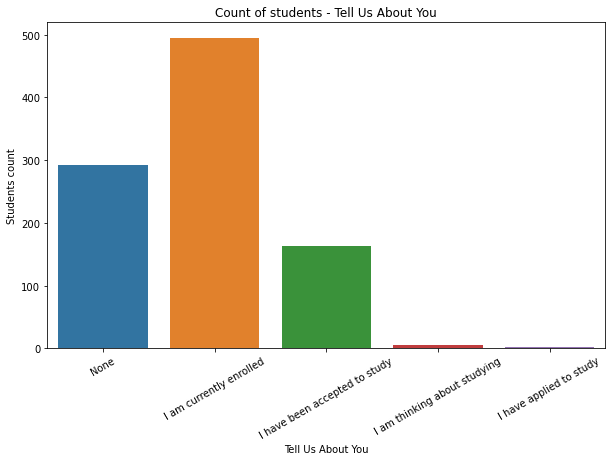

In [222]:
# Students count - Tell Us About You
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Tell Us About You', data=data)
plt.title('Count of students - Tell Us About You')
ax.set(ylabel="Students count")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

In [223]:
# Mean Early Risk Score of the groups
about = data.groupby('Tell Us About You')['Early Risk Score'].mean().reset_index('Tell Us About You')
about.sort_values('Early Risk Score', ascending=False)

,Tell Us About You,Early Risk Score
3,I have been accepted to study,0.601829
4,None,0.584247
0,I am currently enrolled,0.405051
1,I am thinking about studying,0.060000
2,I have applied to study,0.000000


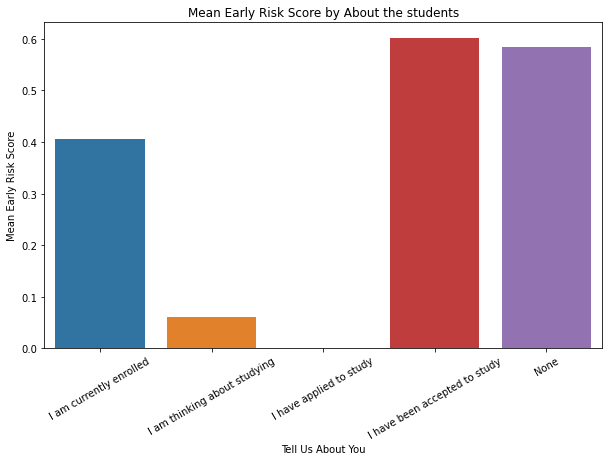

In [224]:
# Plot mean early risk score by About the students
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Tell Us About You", y="Early Risk Score", data=about)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title('Mean Early Risk Score by About the students')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
The students with the status `I have been accepted to study` and the students, who didn't mention anything about themselves are more risky than others.

### Interest Rate

In [225]:
# Count of students
data['Interest Rate'].value_counts()

11.99    767
13.99    134
9.99      47
7.99      10
Name: Interest Rate, dtype: int64

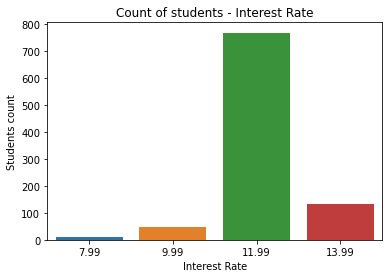

In [226]:
# Students count - Interest Rate
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Interest Rate', data=data)
plt.title('Count of students - Interest Rate')
ax.set(ylabel="Students count")
plt.show()

In [227]:
# Mean Early Risk Score of the groups
ir = data.groupby('Interest Rate')['Early Risk Score'].mean().reset_index('Interest Rate')
ir.sort_values('Early Risk Score', ascending=False)

,Interest Rate,Early Risk Score
1,9.99,0.878723
0,7.99,0.680000
2,11.99,0.469231
3,13.99,0.463433


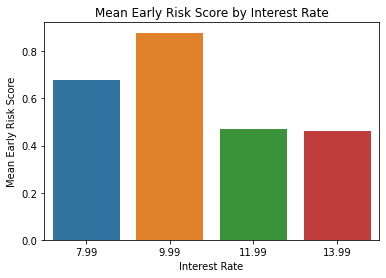

In [228]:
# Plot mean early risk score by Interest Rate
plt.figure(figsize=(6,4))
ax = sns.barplot(x="Interest Rate", y="Early Risk Score", data=ir)
plt.title('Mean Early Risk Score by Interest Rate')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
From the plot, we can see that the Interest Rate 9.99% are the most riksy group followed by the interest rate 7.99%.
But strangely, the higher interest rate group are the less riksy.

### GPA

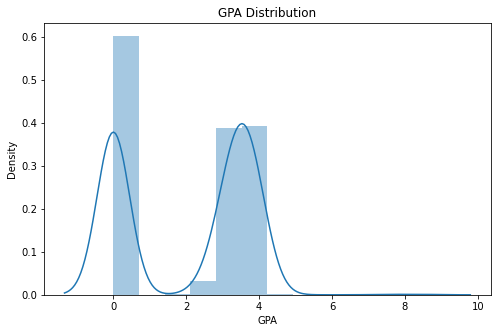

In [229]:
# Distribution of GPA
plt.figure(figsize=(8,5))
sns.distplot(data['GPA'])
plt.title('GPA Distribution')
plt.show()

In [230]:
data['GPA'].describe()

count    958.000000
mean       2.017223
std        1.764030
min        0.000000
25%        0.000000
50%        3.070000
75%        3.600000
max        8.450000
Name: GPA, dtype: float64

We can see that most of the GPAs are zero. Assuming that the GPA is not provided or entered for these students. Approximately 50% of students have GPA lower that 3.07. We are binning the GPA column with High and Low GPA categories.

- Lesser than 3.0 is considered as Low GPA
- Greater that 3.0 is considered as High GPA

In [231]:
# Function for binning GPA
def gpa_bin(x):
    if x < 3:
        return 'Low'
    else:
        return 'High'

In [232]:
# Binning the GPA with High and Low in new column "GPA Bin"
data['GPA Bin'] = data['GPA'].apply(gpa_bin)
data.head()

,Loan Number,Tell Us About You,Has SSN,US Citizen,Enrollment Status,STEM,Credit Score 1,Credit Score 2,GPA,Approved Loan Amount,Interest Rate,Test Loan,Early Risk Score,GPA Bin
0,35,None,Yes,False,2nd Year Graduate,No,630.0,0.0,3.74,15500.0,11.99,0,0.0,High
1,43,None,Yes,False,2nd Year Graduate,No,644.0,NaN,3.86,10446.0,11.99,0,0.0,High
2,63,None,Yes,False,4th Year Undergraduate,No,688.0,NaN,3.20,15000.0,13.99,0,0.0,High
3,65,None,No,False,1st Year Graduate,No,NaN,NaN,0.00,7000.0,11.99,0,0.5,Low
4,66,None,No,True,3rd Year Undergraduate,No,641.0,NaN,3.00,15000.0,9.99,0,0.0,High


In [233]:
# Count of students
data['GPA Bin'].value_counts()

High    516
Low     442
Name: GPA Bin, dtype: int64

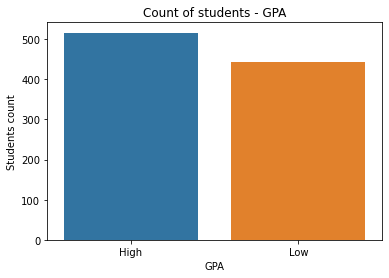

In [234]:
# Students count - GPA Bin
plt.figure(figsize=(6,4))
ax = sns.countplot(x='GPA Bin', data=data)
plt.xlabel('GPA')
plt.title('Count of students - GPA')
ax.set(ylabel="Students count")
plt.show()

In [235]:
# Mean Early Risk Score of the groups
gpa = data.groupby('GPA Bin')['Early Risk Score'].mean().reset_index('GPA Bin')
gpa.sort_values('Early Risk Score', ascending=False)

,GPA Bin,Early Risk Score
1,Low,0.535068
0,High,0.452713


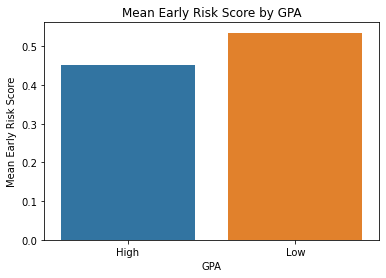

In [236]:
# Plot mean early risk score by GPA
plt.figure(figsize=(6,4))
ax = sns.barplot(x="GPA Bin", y="Early Risk Score", data=gpa)
plt.xlabel('GPA')
plt.title('Mean Early Risk Score by GPA')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
Looks like there is not much difference in the Risk Score with respect to GPA. Hence, GPA is hardly an indicator for the Early Risk Score.

### Approved Loan Amount

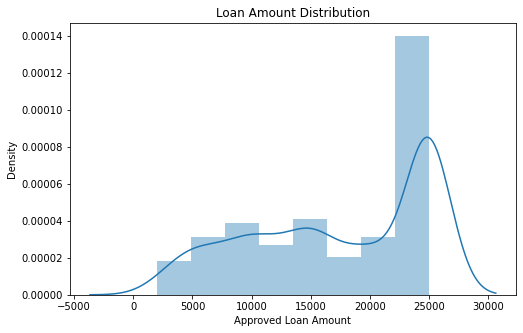

In [237]:
# Distribution of Loan Amount
plt.figure(figsize=(8,5))
sns.distplot(data['Approved Loan Amount'])
plt.title('Loan Amount Distribution')
plt.show()

In [238]:
data['Approved Loan Amount'].describe()

count      958.000000
mean     17397.002985
std       7463.420160
min       2001.000000
25%      10500.000000
50%      18751.000000
75%      25000.000000
max      25000.000000
Name: Approved Loan Amount, dtype: float64

We are creating bins for `Approved Loan Amount` on basis of the above distribution.

Lesser than 14000 :- Low loan amount

Greater than 14000 and lesser than 23000 :- Medium loan amount
 
Greater than 23000 :- High loan amount

In [239]:
# Function for binning approved loan amount
def loan_amount_bin(x):
    if x < 14000:
        return 'Low'
    elif x >= 14000 and x < 23000:
        return 'Medium'
    else:
        return 'High'

In [240]:
# Creating bins
data['Loan Amount Bin'] = data['Approved Loan Amount'].apply(loan_amount_bin)
data

,Loan Number,Tell Us About You,Has SSN,US Citizen,Enrollment Status,STEM,Credit Score 1,Credit Score 2,GPA,Approved Loan Amount,Interest Rate,Test Loan,Early Risk Score,GPA Bin,Loan Amount Bin
0,35,None,Yes,False,2nd Year Graduate,No,630.0,0.0,3.74,15500.0,11.99,0,0.0,High,Medium
1,43,None,Yes,False,2nd Year Graduate,No,644.0,NaN,3.86,10446.0,11.99,0,0.0,High,Low
2,63,None,Yes,False,4th Year Undergraduate,No,688.0,NaN,3.20,15000.0,13.99,0,0.0,High,Medium
3,65,None,No,False,1st Year Graduate,No,NaN,NaN,0.00,7000.0,11.99,0,0.5,Low,Low
4,66,None,No,True,3rd Year Undergraduate,No,641.0,NaN,3.00,15000.0,9.99,0,0.0,High,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,2313,I am currently enrolled,No,False,3rd Year Graduate,No,712.0,0.0,0.00,25000.0,11.99,0,0.0,Low,High
954,2316,I am currently enrolled,No,False,1st Year Graduate,No,NaN,0.0,0.00,10000.0,11.99,0,0.0,Low,Low
955,2317,I am currently enrolled,Yes,False,2nd Year Graduate,No,756.0,0.0,2.80,21000.0,11.99,0,0.0,Low,Medium
956,2318,I am currently enrolled,Yes,False,1st Year Graduate,No,NaN,NaN,3.80,10000.0,11.99,0,0.0,High,Low


In [241]:
# Count of students
data['Loan Amount Bin'].value_counts()

High      384
Low       317
Medium    257
Name: Loan Amount Bin, dtype: int64

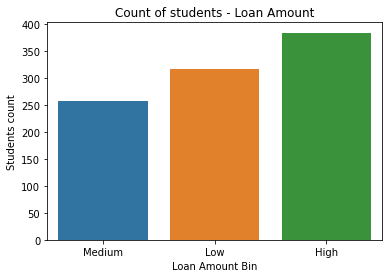

In [242]:
# Students count - Loan Amount Bin
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Loan Amount Bin', data=data)
plt.title('Count of students - Loan Amount')
ax.set(ylabel="Students count")
plt.show()

In [243]:
# Mean Early Risk Score of the groups
loan_amount = data.groupby('Loan Amount Bin')['Early Risk Score'].mean().reset_index('Loan Amount Bin')
loan_amount.sort_values('Early Risk Score', ascending=False)

,Loan Amount Bin,Early Risk Score
1,Low,0.536278
0,High,0.493229
2,Medium,0.430739


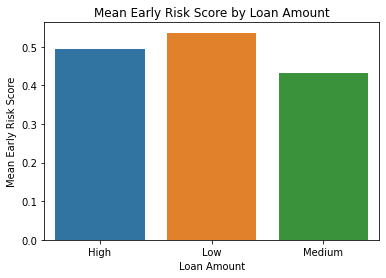

In [244]:
# Plot mean early risk score by Loan Amount Bin
plt.figure(figsize=(6,4))
ax = sns.barplot(x="Loan Amount Bin", y="Early Risk Score", data=loan_amount)
plt.xlabel('Loan Amount')
plt.title('Mean Early Risk Score by Loan Amount')
plt.ylabel('Mean Early Risk Score')
plt.show()

###### Analysis
We can notice that Loan amount is hardly an indicator of the Risk Score as there is very less difference in high, medium and low approved loan amount groups.

### Credit Score 1

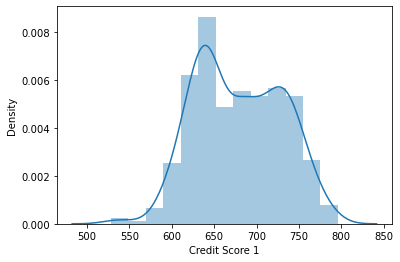

In [245]:
# Distribution
sns.distplot(data['Credit Score 1'])
plt.show()

In [246]:
data['Credit Score 1'].describe()

count    438.000000
mean     678.831050
std       51.168352
min      528.000000
25%      639.000000
50%      677.500000
75%      721.750000
max      796.000000
Name: Credit Score 1, dtype: float64

As we have already seen that the variable has almost 54% missing values. It will be hard and biased to impute those missing values. But as per distribution, we can see that the mean and median is very close. Hence, the data is well distributed. Therefore, we can impute the missing values with mean or median.

In [247]:
# Imputing the missing values with mean
data['Credit Score 1'].fillna(data['Credit Score 1'].mean(), inplace=True)

### Credit Score 2

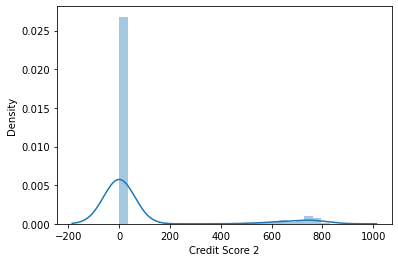

In [248]:
# Distribution
sns.distplot(data['Credit Score 2'])
plt.show()

In [249]:
data['Credit Score 2'].describe()

count    632.000000
mean      79.083861
std      223.989538
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      828.000000
Name: Credit Score 2, dtype: float64

There are 34% missing values in this column. From the distribution, we can see that there is huge deviation in the data. The data is not well distributed. Hence, we are not imputing the missing values for Credit Score 2.

## Bivariate Analysis - Continious variable

### Finding correlation between `Early Risk Score` and other continious variables

In [250]:
# List of the continious variables
num_cols = ['Approved Loan Amount', 'GPA', 'Credit Score 1', 'Credit Score 2', 'Early Risk Score']

In [251]:
# Correlation
data[num_cols].corr()

,Approved Loan Amount,GPA,Credit Score 1,Credit Score 2,Early Risk Score
Approved Loan Amount,1.000000,-0.251860,0.125983,-0.012923,-0.013204
GPA,-0.251860,1.000000,-0.072327,0.022482,-0.054568
Credit Score 1,0.125983,-0.072327,1.000000,-0.017173,-0.098440
Credit Score 2,-0.012923,0.022482,-0.017173,1.000000,-0.007292
Early Risk Score,-0.013204,-0.054568,-0.098440,-0.007292,1.000000


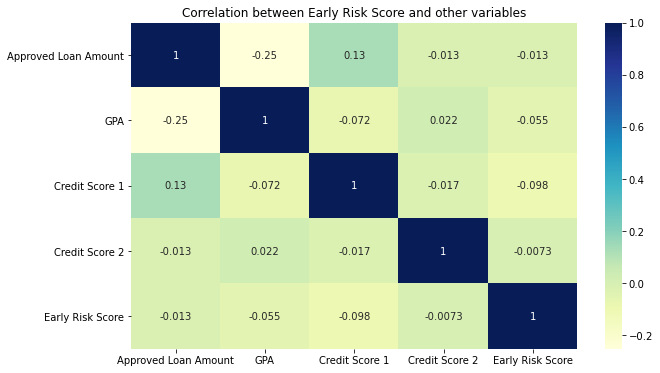

In [252]:
# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data[num_cols].corr(),cmap="YlGnBu",annot=True)
plt.title('Correlation between Early Risk Score and other variables')
plt.show()

###### Analysis
Hardly we can notice any correlation between Risk Score and other variables. Hence, we can conclude that the Risk Score is not much dependent on Credit Score, GPA and Loan Amount.

## Bivariate Analysis - Categorical Variable

### Mean Early Risk Score by - US Citizen and STEM

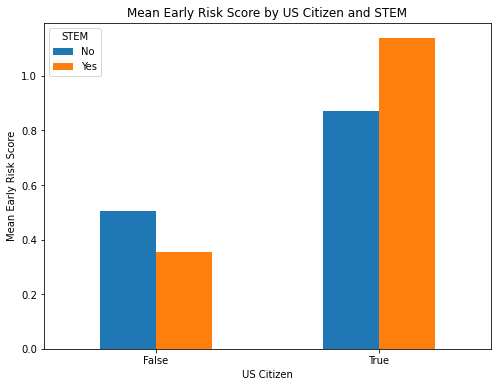

In [253]:
data.pivot_table(values='Early Risk Score',index='US Citizen',columns='STEM',aggfunc='mean').plot.bar(figsize=(8,6), rot=0)
plt.title('Mean Early Risk Score by US Citizen and STEM')
plt.ylabel('Mean Early Risk Score')
plt.show()

Non-US Citizen with STEM course students are the least risky group, whereas US Citizen with STEM course students are the riskiest group.

### Mean Early Risk Score by - US Citizen and SSN

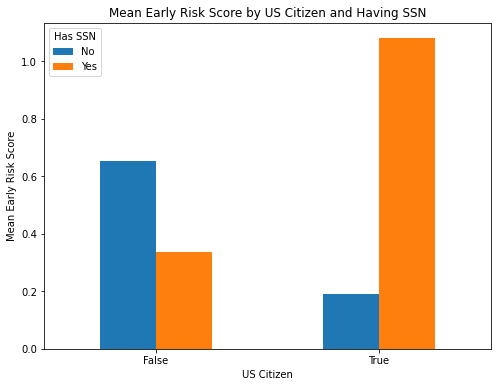

In [254]:
data.pivot_table(values='Early Risk Score',index='US Citizen',columns='Has SSN',aggfunc='mean').plot.bar(figsize=(8,6), rot=0)
plt.title('Mean Early Risk Score by US Citizen and Having SSN')
plt.ylabel('Mean Early Risk Score')
plt.show()

US Citizen students not having SSN are the least risky and US citizen students having SSN are most risky.

### Mean Early Risk Score by - Enrollment Status and STEM

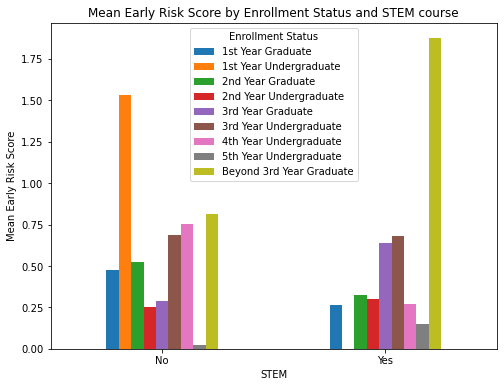

In [255]:
data.pivot_table(values='Early Risk Score',index='STEM',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(8,6), rot=0)
plt.title('Mean Early Risk Score by Enrollment Status and STEM course')
plt.ylabel('Mean Early Risk Score')
plt.show()

Beyond 3rd year graduates with STEM course is the riskiest group and 1st year graduates with STEM course is the least risky group.

### Mean Early Risk Score by - Enrollment Status and US Citizen

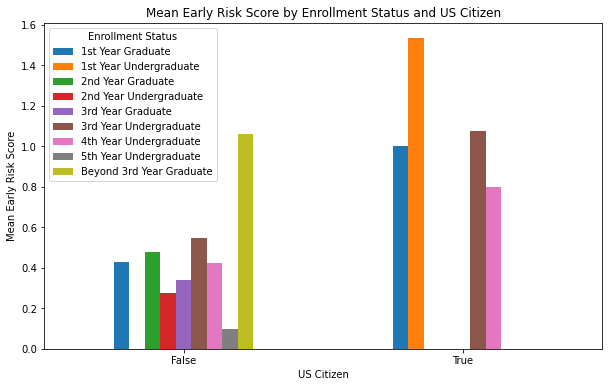

In [256]:
data.pivot_table(values='Early Risk Score',index='US Citizen',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(10,6), rot=0)
plt.title('Mean Early Risk Score by Enrollment Status and US Citizen')
plt.ylabel('Mean Early Risk Score')
plt.show()

### Mean Early Risk Score by - Enrollment Status and Having SSN

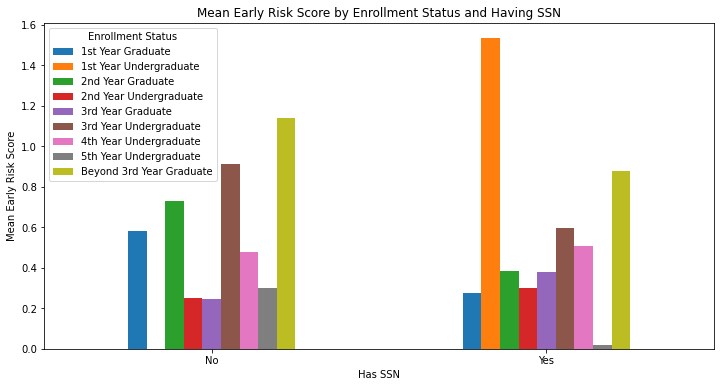

In [257]:
data.pivot_table(values='Early Risk Score',index='Has SSN',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(12,6), rot=0)
plt.title('Mean Early Risk Score by Enrollment Status and Having SSN')
plt.ylabel('Mean Early Risk Score')
plt.show()

### Mean Early Risk Score by - GPA and STEM

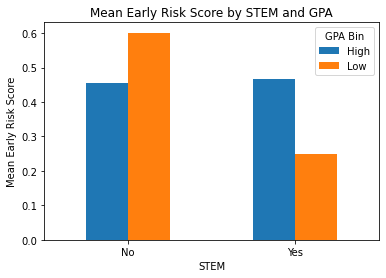

In [258]:
data.pivot_table(values='Early Risk Score',index='STEM',columns='GPA Bin',aggfunc='mean').plot.bar(figsize=(6,4), rot=0)
plt.title('Mean Early Risk Score by STEM and GPA')
plt.ylabel('Mean Early Risk Score')
plt.show()

Students other than STEM course with low GPA are the riskiest group.

### Mean Early Risk Score by - GPA and US Citizen

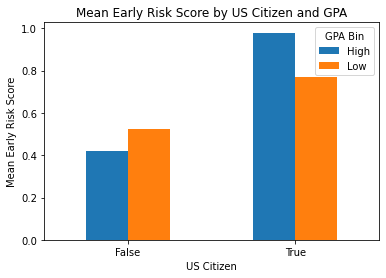

In [259]:
data.pivot_table(values='Early Risk Score',index='US Citizen',columns='GPA Bin',aggfunc='mean').plot.bar(figsize=(6,4), rot=0)
plt.title('Mean Early Risk Score by US Citizen and GPA')
plt.ylabel('Mean Early Risk Score')
plt.show()

Non-US citizen with higher GPA are the least risky students and US citizen with high and low GPA are the riskiest students.

### Mean Early Risk Score by - GPA and Enrollment Status

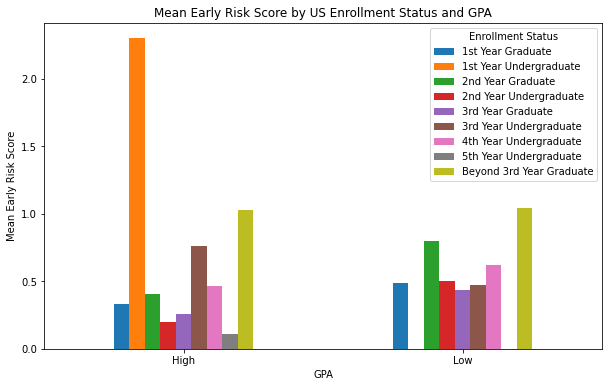

In [260]:
data.pivot_table(values='Early Risk Score',index='GPA Bin',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(10,6), rot=0)
plt.title('Mean Early Risk Score by US Enrollment Status and GPA')
plt.xlabel('GPA')
plt.ylabel('Mean Early Risk Score')
plt.show()

### Mean Early Risk Score by - Interest Rate and STEM

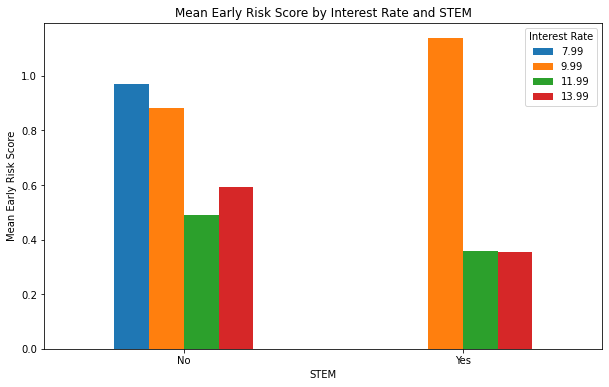

In [261]:
data.pivot_table(values='Early Risk Score',index='STEM',columns='Interest Rate',aggfunc='mean').plot.bar(figsize=(10,6), rot=0)
plt.title('Mean Early Risk Score by Interest Rate and STEM')
plt.ylabel('Mean Early Risk Score')
plt.show()

Students with STEM course and offered loan with higher interest rate have lower risk score. Students with non-STEM course with lower interest rate have higher risk score.

### Mean Early Risk Score by - Interest Rate and Enrollment Status

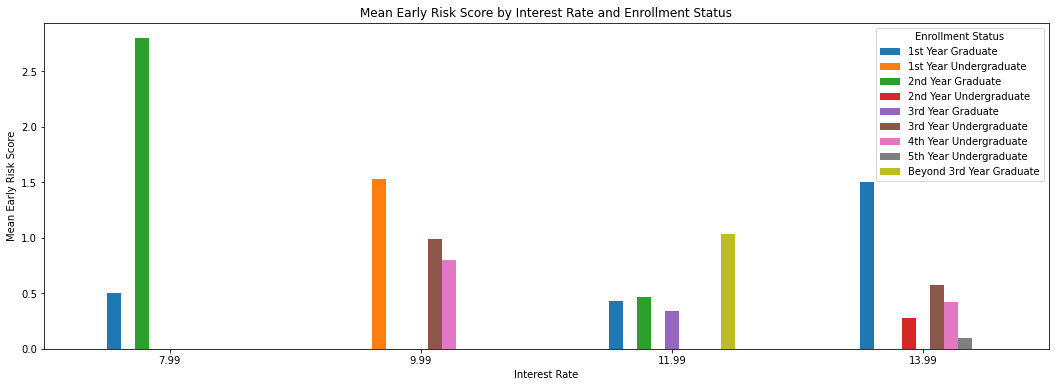

In [262]:
data.pivot_table(values='Early Risk Score',index='Interest Rate',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(18,6), rot=0)
plt.title('Mean Early Risk Score by Interest Rate and Enrollment Status')
plt.ylabel('Mean Early Risk Score')
plt.show()

### Mean Early Risk Score by - Enrollment Status and US Citizen

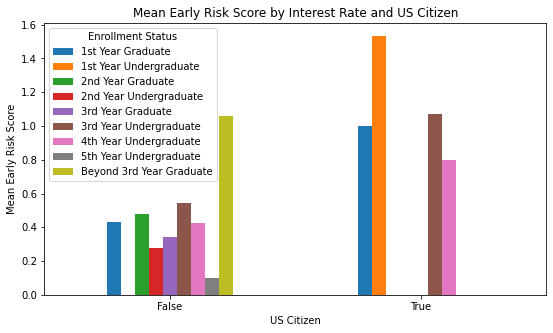

In [263]:
data.pivot_table(values='Early Risk Score',index='US Citizen',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(9,5), rot=0)
plt.title('Mean Early Risk Score by Interest Rate and US Citizen')
plt.ylabel('Mean Early Risk Score')
plt.show()

### Mean Early Risk Score by - Loan Amount and Interest Rate

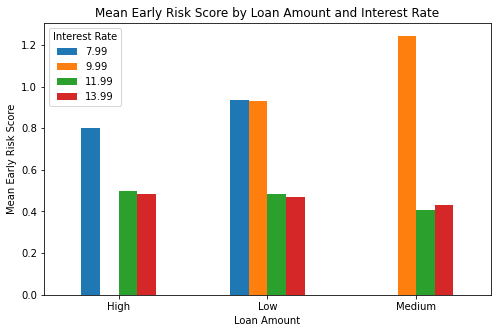

In [264]:
data.pivot_table(values='Early Risk Score',index='Loan Amount Bin',columns='Interest Rate',aggfunc='mean').plot.bar(figsize=(8,5), rot=0)
plt.title('Mean Early Risk Score by Loan Amount and Interest Rate')
plt.xlabel('Loan Amount')
plt.ylabel('Mean Early Risk Score')
plt.show()

Irrespective of the loan amount the lower interest rate loans are more risky than higher interest rate.

### Mean Early Risk Score by - Loan Amount and STEM

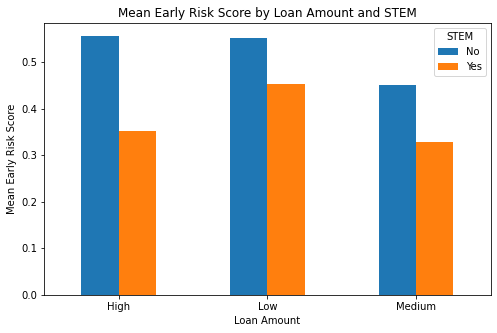

In [265]:
data.pivot_table(values='Early Risk Score',index='Loan Amount Bin',columns='STEM',aggfunc='mean').plot.bar(figsize=(8,5), rot=0)
plt.title('Mean Early Risk Score by Loan Amount and STEM')
plt.xlabel('Loan Amount')
plt.ylabel('Mean Early Risk Score')
plt.show()

Students enrolled with STEM course and offered higher loan amount are less likely to be riskier than the non-STEM students with high loan amount.

### Mean Early Risk Score by - Loan Amount and GPA

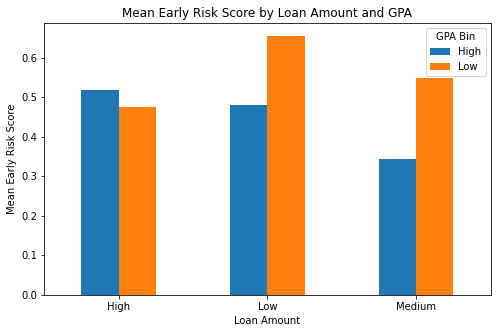

In [266]:
data.pivot_table(values='Early Risk Score',index='Loan Amount Bin',columns='GPA Bin',aggfunc='mean').plot.bar(figsize=(8,5), rot=0)
plt.title('Mean Early Risk Score by Loan Amount and GPA')
plt.xlabel('Loan Amount')
plt.ylabel('Mean Early Risk Score')
plt.show()

Students with low GPA and offered with low loan amount are slightly riskier than the other groups.

### Mean Early Risk Score by - Loan Amount and US Citizen

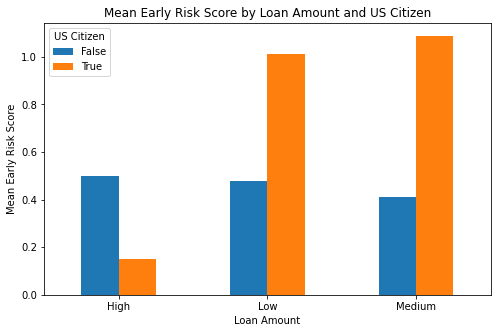

In [267]:
data.pivot_table(values='Early Risk Score',index='Loan Amount Bin',columns='US Citizen',aggfunc='mean').plot.bar(figsize=(8,5), rot=0)
plt.title('Mean Early Risk Score by Loan Amount and US Citizen')
plt.xlabel('Loan Amount')
plt.ylabel('Mean Early Risk Score')
plt.show()

US Citizen students with higher loan amount are less risky that US citizen students with lower loan amount.

### Mean Early Risk Score by - Loan Amount and Enrollment Status

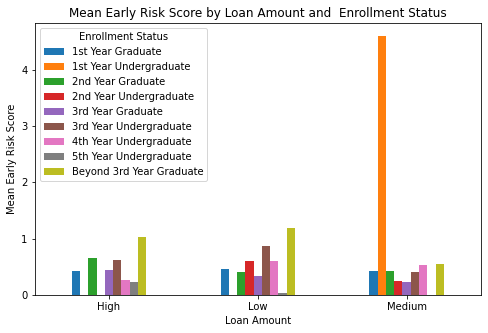

In [268]:
data.pivot_table(values='Early Risk Score',index='Loan Amount Bin',columns='Enrollment Status',aggfunc='mean').plot.bar(figsize=(8,5), rot=0)
plt.title('Mean Early Risk Score by Loan Amount and  Enrollment Status')
plt.xlabel('Loan Amount')
plt.ylabel('Mean Early Risk Score')
plt.show()